## Import Dependencies

In [2]:
import talib
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data source
import quandl as q

# machine & deep learning
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, cross_validation, svm
import tensorflow as tf

# measure results
from sklearn.metrics import r2_score

## Datasets & Inputs

In [3]:
df = pd.read_csv("data/btc-usd.csv")
df.head()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
0,2016-01-01,436.49,426.26,433.910,433.78,433.83,433.99,12922.080199
1,2016-01-02,435.80,430.00,433.330,433.20,433.20,433.46,6658.092194
2,2016-01-03,433.79,421.73,427.905,427.98,427.76,428.05,18644.760056
3,2016-01-04,435.67,426.20,434.475,434.49,434.47,434.48,13092.850666
4,2016-01-05,434.91,427.91,432.090,431.82,431.96,432.22,11532.984890


In [4]:
df.tail()

,Date,High,Low,Mid,Last,Bid,Ask,Volume
959,2018-09-04,7415.4,7246.2,7360.65,7360.700000,7360.6,7360.7,21047.188306
960,2018-09-05,7404.0,6900.0,6906.25,6906.000000,6906.2,6906.3,46598.570547
961,2018-09-06,6932.9,6302.2,6456.50,6454.200000,6456.4,6456.6,61607.045343
962,2018-09-07,6549.5,6322.8,6412.50,6412.594448,6412.4,6412.6,21379.071539
963,2018-09-08,6475.5,6119.5,6175.85,6175.900000,6175.8,6175.9,21694.860747


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 8 columns):
Date      964 non-null object
High      964 non-null float64
Low       964 non-null float64
Mid       964 non-null float64
Last      964 non-null float64
Bid       964 non-null float64
Ask       964 non-null float64
Volume    964 non-null float64
dtypes: float64(7), object(1)
memory usage: 60.3+ KB


In [6]:
df['Last'].max()

19210.0

In [7]:
df['Last'].min()

359.16

In [8]:
df['Last'].mean()

3869.4590118944707

In [9]:
df['Last'].median()

1775.0

## Exploratory Data Analysis

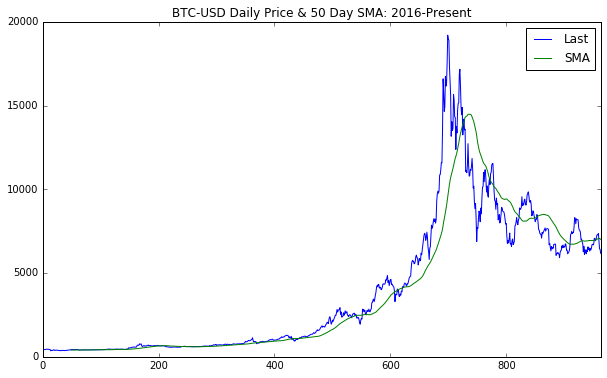

In [10]:
# Calculate & display 50 day SMA
df['SMA'] = df['Last'].rolling(50).mean()

df[['Last', 'SMA']].plot(title='BTC-USD Daily Price & 50 Day SMA: 2016-Present',figsize=(10,6))

#### Daily Percent Changes

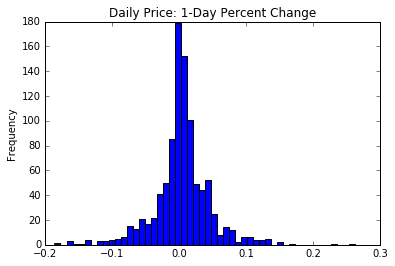

In [11]:
# Histogram of the daily price change percent of 'Last' price
df['Last'].pct_change().plot.hist(bins=50)
plt.title('Daily Price: 1-Day Percent Change')
plt.show()

In [12]:
# Create 5-day % changes of Last for the current day, and 5 days in the future
df['5d_future_close'] = df['Last'].shift(-5)
df['5d_close_future_pct'] = df['5d_future_close'].pct_change(5)
df['5d_close_pct'] = df['Last'].pct_change(5)

In [13]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000             0.037214
5d_close_future_pct      0.037214             1.000000


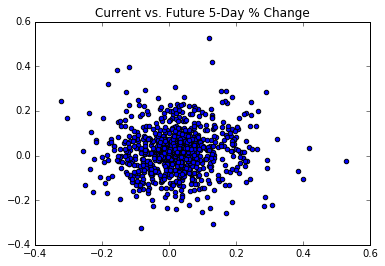

In [14]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(df['5d_close_pct'], df['5d_close_future_pct'])
plt.title('Current vs. Future 5-Day % Change')
plt.show()

## Preparing Our Data for ML

In [15]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create SMA moving averages and rsi for timeperiods of 14, 30, and 50
for n in [14, 30, 50]:

    # Create the SMA indicator and divide by 'Last'
    df['ma' + str(n)] = talib.SMA(df['Last'].values,
                              timeperiod=n) / df['Last']
    
    # Add SMA to the feature name list
    feature_names = feature_names + ['ma' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'ma30', 'ma50']


In [16]:
# Drop all na values
df = df.dropna()

# Create features and targets
# use feature_names for features; 5d_close_future_pct for targets
features = df[feature_names]
targets = df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feat_targ_df = df[['5d_close_future_pct'] + feature_names]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     5d_close_future_pct  5d_close_pct      ma14      ma30  \
5d_close_future_pct             1.000000      0.040338 -0.029301 -0.053931   
5d_close_pct                    0.040338      1.000000 -0.850392 -0.663473   
ma14                           -0.029301     -0.850392  1.000000  0.867678   
ma30                           -0.053931     -0.663473  0.867678  1.000000   
ma50                           -0.032572     -0.522106  0.707336  0.926667   

                         ma50  
5d_close_future_pct -0.032572  
5d_close_pct        -0.522106  
ma14                 0.707336  
ma30                 0.926667  
ma50                 1.000000  


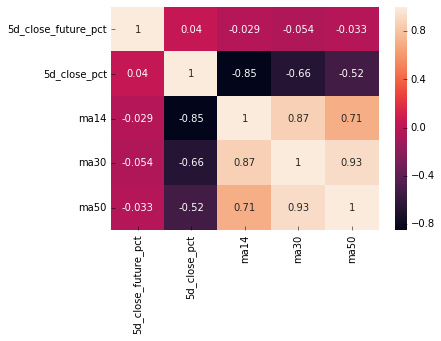

In [17]:
import seaborn as sns

# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.show()  # show the plot

## Linear Models

#### First a quick review of linear regression

In [18]:
# generate evenly spaced grid for x values 0-10
x = np.linspace(0, 10)

# generate randomized data for y values
y = x + np.random.standard_normal(len(x))

# calculate OLS regression of degree 1
reg = np.polyfit(x, y, deg=1)

# print optimal parameter values
reg

array([0.97695068, 0.18388525])

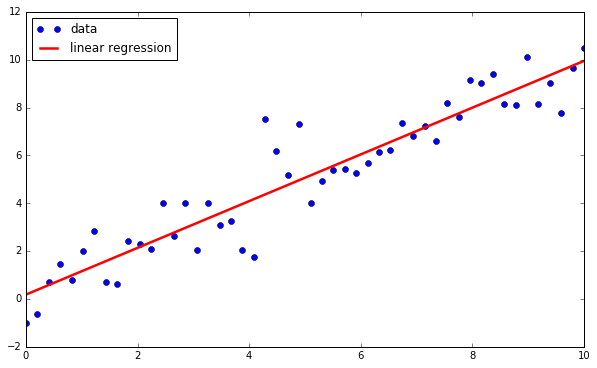

In [19]:
plt.figure(figsize=(10, 6)) # create new figure object
plt.plot(x, y, 'bo', label='data') # plot original data as dots
plt.plot(x, np.polyval(reg, x), 'r', lw=2.5, label='linear regression') # plot regression line
plt.legend(loc=0) # create legend

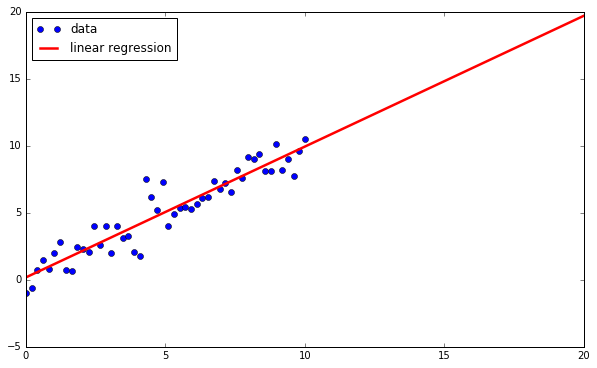

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', label='data')
xn = np.linspace(0, 20) # generate an increased number of x values
plt.plot(xn, np.polyval(reg, xn), 'r', lw=2.5, label='linear regression')
plt.legend(loc=0)

#### Now we split the data into training and test sets.

In [21]:
# import the statsmodels library with the alias sm
import statsmodels.api as sm
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 80% of the total number of rows
#.shape gives us the number of rows in our data, and convert to an int
train_size = int(0.8 * features.shape[0])

# split features and targets using python indexing
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(910, 5) (728, 5) (182, 5)


### Fit a linear model

In [22]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                            
Dep. Variable:     5d_close_future_pct   R-squared:                       0.017
Model:                             OLS   Adj. R-squared:                  0.012
Method:                  Least Squares   F-statistic:                     3.214
Date:                 Tue, 16 Oct 2018   Prob (F-statistic):             0.0125
Time:                         13:52:50   Log-Likelihood:                 657.71
No. Observations:                  728   AIC:                            -1305.
Df Residuals:                      723   BIC:                            -1282.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1426      0.089    

## Neural Networks

#### Standardizing Our Data

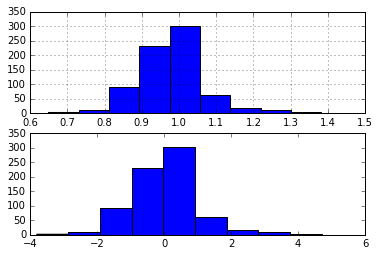

In [26]:
from sklearn.preprocessing import scale

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the features before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

Epoch 1/25
728/728 [==============================] - 1s 1ms/step - loss: 0.0351
Epoch 2/25
728/728 [==============================] - 0s 147us/step - loss: 0.0180
Epoch 3/25
728/728 [==============================] - 0s 111us/step - loss: 0.0135
Epoch 4/25
728/728 [==============================] - 0s 140us/step - loss: 0.0120
Epoch 5/25
728/728 [==============================] - 0s 112us/step - loss: 0.0113
Epoch 6/25
728/728 [==============================] - 0s 90us/step - loss: 0.0108
Epoch 7/25
728/728 [==============================] - 0s 93us/step - loss: 0.0106
Epoch 8/25
728/728 [==============================] - 0s 95us/step - loss: 0.0105
Epoch 9/25
728/728 [==============================] - 0s 103us/step - loss: 0.0102
Epoch 10/25
728/728 [==============================] - 0s 115us/step - loss: 0.0100
Epoch 11/25
728/728 [==============================] - 0s 98us/step - loss: 0.0099
Epoch 12/25
728/728 [==============================] - 0s 114us/step - loss: 0.0098
Epoch 1

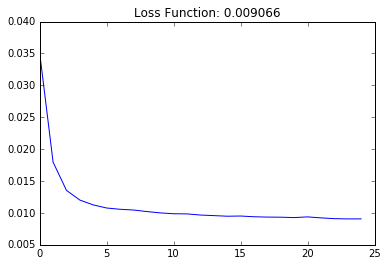

Epoch 1/25
728/728 [==============================] - 0s 640us/step - loss: 0.3803
Epoch 2/25
728/728 [==============================] - 0s 64us/step - loss: 0.0829
Epoch 3/25
728/728 [==============================] - 0s 77us/step - loss: 0.0330
Epoch 4/25
728/728 [==============================] - 0s 62us/step - loss: 0.0209
Epoch 5/25
728/728 [==============================] - 0s 59us/step - loss: 0.0167
Epoch 6/25
728/728 [==============================] - 0s 62us/step - loss: 0.0147
Epoch 7/25
728/728 [==============================] - 0s 93us/step - loss: 0.0135
Epoch 8/25
728/728 [==============================] - 0s 87us/step - loss: 0.0127
Epoch 9/25
728/728 [==============================] - 0s 65us/step - loss: 0.0120
Epoch 10/25
728/728 [==============================] - 0s 56us/step - loss: 0.0117
Epoch 11/25
728/728 [==============================] - 0s 61us/step - loss: 0.0111
Epoch 12/25
728/728 [==============================] - 0s 61us/step - loss: 0.0109
Epoch 13/25


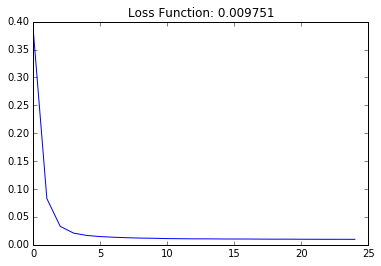

Epoch 1/50
728/728 [==============================] - 0s 565us/step - loss: 0.0425
Epoch 2/50
728/728 [==============================] - 0s 64us/step - loss: 0.0186
Epoch 3/50
728/728 [==============================] - 0s 81us/step - loss: 0.0144
Epoch 4/50
728/728 [==============================] - 0s 57us/step - loss: 0.0128
Epoch 5/50
728/728 [==============================] - 0s 59us/step - loss: 0.0120
Epoch 6/50
728/728 [==============================] - 0s 89us/step - loss: 0.0115
Epoch 7/50
728/728 [==============================] - 0s 58us/step - loss: 0.0110
Epoch 8/50
728/728 [==============================] - 0s 77us/step - loss: 0.0108
Epoch 9/50
728/728 [==============================] - 0s 62us/step - loss: 0.0103
Epoch 10/50
728/728 [==============================] - 0s 86us/step - loss: 0.0104
Epoch 11/50
728/728 [==============================] - 0s 71us/step - loss: 0.0099
Epoch 12/50
728/728 [==============================] - 0s 59us/step - loss: 0.0098
Epoch 13/50


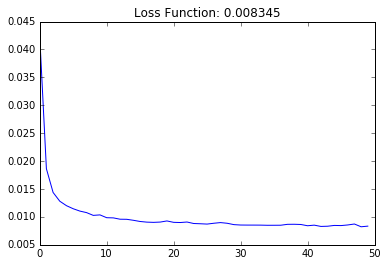

Epoch 1/50
728/728 [==============================] - 0s 626us/step - loss: 0.0261
Epoch 2/50
728/728 [==============================] - 0s 66us/step - loss: 0.0138
Epoch 3/50
728/728 [==============================] - 0s 60us/step - loss: 0.0116
Epoch 4/50
728/728 [==============================] - 0s 64us/step - loss: 0.0108
Epoch 5/50
728/728 [==============================] - 0s 81us/step - loss: 0.0101
Epoch 6/50
728/728 [==============================] - 0s 66us/step - loss: 0.0098
Epoch 7/50
728/728 [==============================] - 0s 80us/step - loss: 0.0096
Epoch 8/50
728/728 [==============================] - 0s 56us/step - loss: 0.0094
Epoch 9/50
728/728 [==============================] - 0s 55us/step - loss: 0.0092
Epoch 10/50
728/728 [==============================] - 0s 68us/step - loss: 0.0091
Epoch 11/50
728/728 [==============================] - 0s 60us/step - loss: 0.0091
Epoch 12/50
728/728 [==============================] - 0s 59us/step - loss: 0.0089
Epoch 13/50


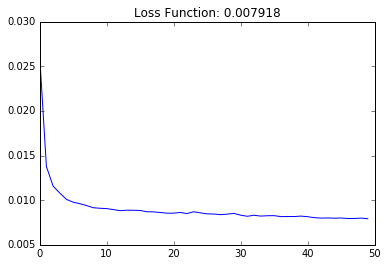

Epoch 1/75
728/728 [==============================] - 0s 655us/step - loss: 0.0732
Epoch 2/75
728/728 [==============================] - 0s 65us/step - loss: 0.0258
Epoch 3/75
728/728 [==============================] - 0s 58us/step - loss: 0.0192
Epoch 4/75
728/728 [==============================] - 0s 55us/step - loss: 0.0156
Epoch 5/75
728/728 [==============================] - 0s 63us/step - loss: 0.0135
Epoch 6/75
728/728 [==============================] - 0s 60us/step - loss: 0.0120
Epoch 7/75
728/728 [==============================] - 0s 55us/step - loss: 0.0112
Epoch 8/75
728/728 [==============================] - 0s 58us/step - loss: 0.0105
Epoch 9/75
728/728 [==============================] - 0s 56us/step - loss: 0.0102
Epoch 10/75
728/728 [==============================] - 0s 57us/step - loss: 0.0101
Epoch 11/75
728/728 [==============================] - 0s 58us/step - loss: 0.0098
Epoch 12/75
728/728 [==============================] - 0s 57us/step - loss: 0.0097
Epoch 13/75


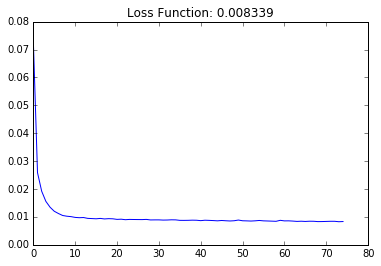

Epoch 1/75
728/728 [==============================] - 0s 684us/step - loss: 0.0414
Epoch 2/75
728/728 [==============================] - 0s 62us/step - loss: 0.0159
Epoch 3/75
728/728 [==============================] - 0s 61us/step - loss: 0.0128
Epoch 4/75
728/728 [==============================] - 0s 63us/step - loss: 0.0119
Epoch 5/75
728/728 [==============================] - 0s 58us/step - loss: 0.0113
Epoch 6/75
728/728 [==============================] - 0s 58us/step - loss: 0.0109
Epoch 7/75
728/728 [==============================] - 0s 59us/step - loss: 0.0105
Epoch 8/75
728/728 [==============================] - 0s 69us/step - loss: 0.0102
Epoch 9/75
728/728 [==============================] - 0s 63us/step - loss: 0.0098
Epoch 10/75
728/728 [==============================] - 0s 62us/step - loss: 0.0096
Epoch 11/75
728/728 [==============================] - 0s 58us/step - loss: 0.0093
Epoch 12/75
728/728 [==============================] - 0s 56us/step - loss: 0.0092
Epoch 13/75


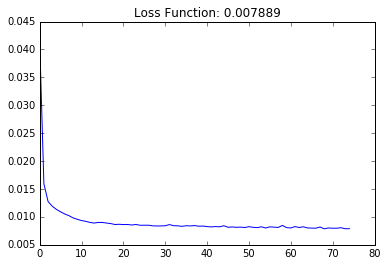

Epoch 1/100
728/728 [==============================] - 1s 721us/step - loss: 0.0251
Epoch 2/100
728/728 [==============================] - 0s 62us/step - loss: 0.0143
Epoch 3/100
728/728 [==============================] - 0s 64us/step - loss: 0.0121
Epoch 4/100
728/728 [==============================] - 0s 56us/step - loss: 0.0111
Epoch 5/100
728/728 [==============================] - 0s 63us/step - loss: 0.0108
Epoch 6/100
728/728 [==============================] - 0s 58us/step - loss: 0.0104
Epoch 7/100
728/728 [==============================] - 0s 65us/step - loss: 0.0101
Epoch 8/100
728/728 [==============================] - 0s 60us/step - loss: 0.0099
Epoch 9/100
728/728 [==============================] - 0s 58us/step - loss: 0.0097
Epoch 10/100
728/728 [==============================] - 0s 57us/step - loss: 0.0095
Epoch 11/100
728/728 [==============================] - 0s 56us/step - loss: 0.0095
Epoch 12/100
728/728 [==============================] - 0s 64us/step - loss: 0.0095


728/728 [==============================] - 0s 58us/step - loss: 0.0083
Epoch 99/100
728/728 [==============================] - 0s 58us/step - loss: 0.0084
Epoch 100/100
728/728 [==============================] - 0s 58us/step - loss: 0.0084
1  mean is:  0.037744593  variance is:  0.0016147007


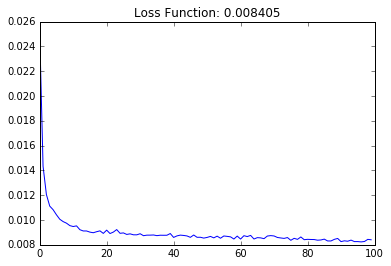

Epoch 1/100
728/728 [==============================] - 1s 790us/step - loss: 0.0178
Epoch 2/100
728/728 [==============================] - 0s 57us/step - loss: 0.0130
Epoch 3/100
728/728 [==============================] - 0s 58us/step - loss: 0.0119
Epoch 4/100
728/728 [==============================] - 0s 58us/step - loss: 0.0114
Epoch 5/100
728/728 [==============================] - 0s 58us/step - loss: 0.0111
Epoch 6/100
728/728 [==============================] - 0s 57us/step - loss: 0.0105
Epoch 7/100
728/728 [==============================] - 0s 56us/step - loss: 0.0101
Epoch 8/100
728/728 [==============================] - 0s 62us/step - loss: 0.0098
Epoch 9/100
728/728 [==============================] - 0s 60us/step - loss: 0.0097
Epoch 10/100
728/728 [==============================] - 0s 67us/step - loss: 0.0096
Epoch 11/100
728/728 [==============================] - 0s 57us/step - loss: 0.0093
Epoch 12/100
728/728 [==============================] - 0s 58us/step - loss: 0.0094


728/728 [==============================] - 0s 64us/step - loss: 0.0073
Epoch 99/100
728/728 [==============================] - 0s 58us/step - loss: 0.0073
Epoch 100/100
728/728 [==============================] - 0s 60us/step - loss: 0.0073
1  mean is:  0.024924599  variance is:  0.0019143736


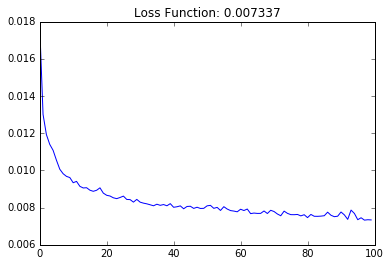

In [29]:
from keras.models import Sequential
from keras.layers import Dense

epochs =[25, 50, 75, 100]
layers = [[10,20,1], [15,20,1]]
# Create the model
def model_func(layer):
    model_1 = Sequential()
    model_1.add(Dense(layer[0], input_dim=scaled_train_features.shape[1], activation='relu'))
    model_1.add(Dense(layer[1], activation='relu'))
    model_1.add(Dense(layer[2], activation='linear'))
    return model_1

# Fit the model
model = 1
final_model = None
max = -100000
for epoch in epochs:
    for layer in layers:
        model_1 = model_func(layer)
        model_1.compile(optimizer='adam', loss='mse')
        history = model_1.fit(scaled_train_features, train_targets, epochs=epoch)
        train_preds = model_1.predict(scaled_train_features)
        print (model, " mean is: ", np.mean(train_preds), " variance is: ", np.var(train_preds))
        if(max < r2_score(train_targets, train_preds)):
            max = r2_score(train_targets, train_preds)
            final_model = model_1
        
        plt.plot(history.history['loss'])

        # Use the last loss as the title
        plt.title('Loss Function: ' + str(round(history.history['loss'][-1], 6)))
        plt.show()

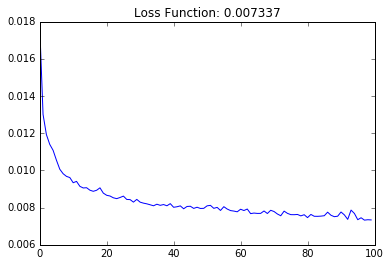

In [30]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('Loss Function: ' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [31]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = final_model.predict(scaled_train_features)
test_preds = final_model.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

0.2665895316547897
-0.15807545123265498


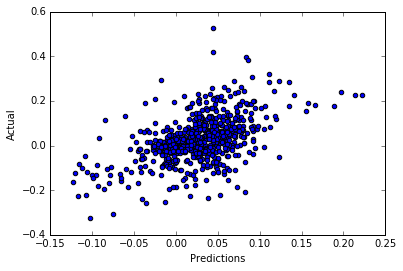

In [32]:
# Plot predictions vs actual
plt.scatter(train_preds, train_targets)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.show()

### Custom Loss Function

In [33]:
# code inspired by Machine Learning for Finance - DataCamp course [6]
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x1c262dd840>


Epoch 1/100
728/728 [==============================] - 1s 1ms/step - loss: 0.7378
Epoch 2/100
728/728 [==============================] - 0s 147us/step - loss: 0.4923
Epoch 3/100
728/728 [==============================] - 0s 91us/step - loss: 0.4623
Epoch 4/100
728/728 [==============================] - 0s 100us/step - loss: 0.4568
Epoch 5/100
728/728 [==============================] - 0s 160us/step - loss: 0.3880
Epoch 6/100
728/728 [==============================] - 0s 143us/step - loss: 0.3754
Epoch 7/100
728/728 [==============================] - 0s 127us/step - loss: 0.4256
Epoch 8/100
728/728 [==============================] - 0s 198us/step - loss: 0.3817
Epoch 9/100
728/728 [==============================] - 0s 107us/step - loss: 0.3408
Epoch 10/100
728/728 [==============================] - 0s 116us/step - loss: 0.3993
Epoch 11/100
728/728 [==============================] - 0s 99us/step - loss: 0.3501
Epoch 12/100
728/728 [==============================] - 0s 138us/step - loss: 

728/728 [==============================] - 0s 92us/step - loss: 0.2562
Epoch 99/100
728/728 [==============================] - 0s 97us/step - loss: 0.2651
Epoch 100/100
728/728 [==============================] - 0s 79us/step - loss: 0.2728


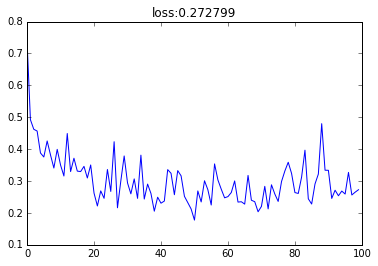

In [38]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=100)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

0.011221982594932567
-0.015075338026476981


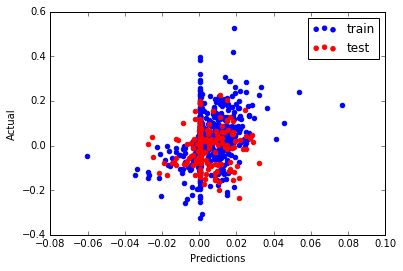

In [39]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train', color='blue')
plt.scatter(test_preds, test_targets, label='test', color='red')  # plot test set
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.legend(); plt.show()